# Recreating Irfan, 2020: *A Novel Feature Extraction Model to Enhance Underwater Image Classification*

In [18]:
import tensorflow as tf
import keras
from keras import layers, optimizers, losses
import pandas as pd
import numpy as np
import os
import PIL
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px

## Loading data 

In [3]:
# Load data and resize each image to 96x96

ROOT_DIR = 'fish4knowledge/'
DESIRED_IMAGE_SIZE = (96, 96)
NUM_CLASSES = 23

X = []
y = []
for img_class in os.listdir(ROOT_DIR):
    class_path = os.path.join(ROOT_DIR, img_class)
    for png in os.listdir(class_path):
        img_path = os.path.join(class_path, png) 
        fish = PIL.Image.open(img_path)
        fish = fish.resize(DESIRED_IMAGE_SIZE)
        pixels = np.array(fish)

        X.append(pixels)
        y.append(int(img_class))

X = np.array(X)
y = np.array(y)

In [4]:
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (27370, 96, 96, 3)
y.shape: (27370,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=0.7,
    shuffle=True,
    random_state=42
)

In [6]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (19159, 96, 96, 3)
y_train.shape: (19159,)
X_test.shape: (8211, 96, 96, 3)
y_test.shape: (8211,)


## Model architecture + training

In [7]:
class Conv2DWithBatchNorm(layers.Layer):
    def __init__(self, conv_filters, kernel_size=(3, 3), conv_padding='same',
                 conv_strides=1, transpose=False):
        '''
        In Irfan et al's model, each Conv2D or Conv2DTranspose is followed by
        a BatchNorm and ReLU as activation. This `keras.Layer` combines the
        three components into one object.
        '''

        super(Conv2DWithBatchNorm, self).__init__()

        if transpose:
            self.conv = layers.Conv2DTranspose(
                filters=conv_filters,
                kernel_size=kernel_size, 
                strides=conv_strides, 
                padding=conv_padding
            )
        else:
            self.conv = layers.Conv2D(
                filters=conv_filters,
                kernel_size=kernel_size, 
                strides=conv_strides, 
                padding=conv_padding
            )
        self.bn = layers.BatchNormalization()
        self.activation = layers.Activation('relu')

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.activation(x)
        return x

In [8]:
def conv_block(x, conv_filters, kernel_size=(3, 3), conv_padding='same', 
               conv_strides=1, use_pool=None, pool_size=(2, 2), pool_strides=2):
    
    x = Conv2DWithBatchNorm(
        conv_filters=conv_filters, 
        kernel_size=kernel_size, 
        conv_strides=conv_strides, 
        conv_padding=conv_padding,
        transpose=False
    )(x)

    if use_pool == 'max':
        x = layers.MaxPooling2D(
            pool_size=pool_size, 
            strides=pool_strides
        )(x)
    elif use_pool == 'avg':
        x = layers.AveragePooling2D(
            pool_size=pool_size, 
            strides=pool_strides
        )(x)

    return x

In [9]:
def deconv_block(x, conv_filters, kernel_size=(3, 3), conv_padding='same', 
                 conv_strides=1, upsampling_size=(2, 2)):

    x = layers.UpSampling2D(size=upsampling_size, interpolation='bilinear')(x)

    x = Conv2DWithBatchNorm(
        conv_filters=conv_filters, 
        kernel_size=kernel_size, 
        conv_strides=conv_strides,
        conv_padding=conv_padding,
        transpose=True
    )(x)
    
    return x

In [10]:
# FUNCTIONAL API

tf.keras.backend.clear_session()

encoder_input = layers.Input(shape=(96, 96, 3), name='input')

block1 = conv_block(encoder_input, conv_filters=64, use_pool=None)
block2 = conv_block(block1, conv_filters=64, use_pool='max')
block3 = conv_block(block2, conv_filters=64, use_pool='max')
block4 = conv_block(block3, conv_filters=128, use_pool='max')
block5_1 = conv_block(block4, conv_filters=256, use_pool=None)
block5_2 = conv_block(block5_1, conv_filters=256, use_pool='max')
block6_1 = conv_block(block5_2, conv_filters=512, use_pool=None)
block6_2 = conv_block(block6_1, conv_filters=512, use_pool='avg', 
                      pool_size=(6, 6), pool_strides=1)

# Dimensions: (1, 1, 512) --> (512)
flatten = layers.Flatten()(block6_2)

# Output of the average pooling layer is first flattened (reshaped) and then it
# is given as an input to softmax classifier.
classification = layers.Dense(NUM_CLASSES)(flatten)
classification = layers.Softmax()(classification)

# For latent space visualisation purposes, reduce inputs into 3D.
viz = layers.Dense(3)(flatten)
encoder = keras.Model(inputs=encoder_input, outputs=viz)

block7_1 = Conv2DWithBatchNorm(conv_filters=512, kernel_size=(1, 1), 
                               transpose=True)(block6_2)
block7_2 = deconv_block(block7_1, conv_filters=512, upsampling_size=(6, 6))
block7_3 = Conv2DWithBatchNorm(conv_filters=512, kernel_size=(3, 3), 
                               transpose=True)(block7_2)
block8_1 = deconv_block(block7_3, conv_filters=256)
block8_2 = Conv2DWithBatchNorm(conv_filters=256, kernel_size=(3, 3), 
                               transpose=True)(block8_1)
block9 = deconv_block(block8_2, conv_filters=128)
block10 = deconv_block(block9, conv_filters=64)

decoder_output = deconv_block(block10, conv_filters=3)

In [11]:
viz_predictions = encoder.predict(X_test)

257/257 [==============================] - 4s 9ms/step


In [12]:
predictions = pd.DataFrame(viz_predictions, columns=['x', 'y', 'z'])
predictions['class'] = y_test
predictions.head()

,x,y,z,class
0,-0.559874,0.257360,-3.742933,0
1,-0.453747,0.129716,-3.783545,0
2,-0.586319,0.432233,-3.290856,0
3,-0.224685,0.196741,-3.053332,7
4,-0.608888,0.492102,-3.082777,5


In [19]:
fig = px.scatter_3d(predictions, x='x', y='y', z='z', color='class')
fig.show()

### Training

In [14]:
irfan2020 = keras.Model(
    inputs=encoder_input,
    outputs=[decoder_output, classification],
    name="irfan_2020"
)

irfan2020.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss=[losses.MeanSquaredError(), losses.SparseCategoricalCrossentropy()],
    metrics=['accuracy']
)

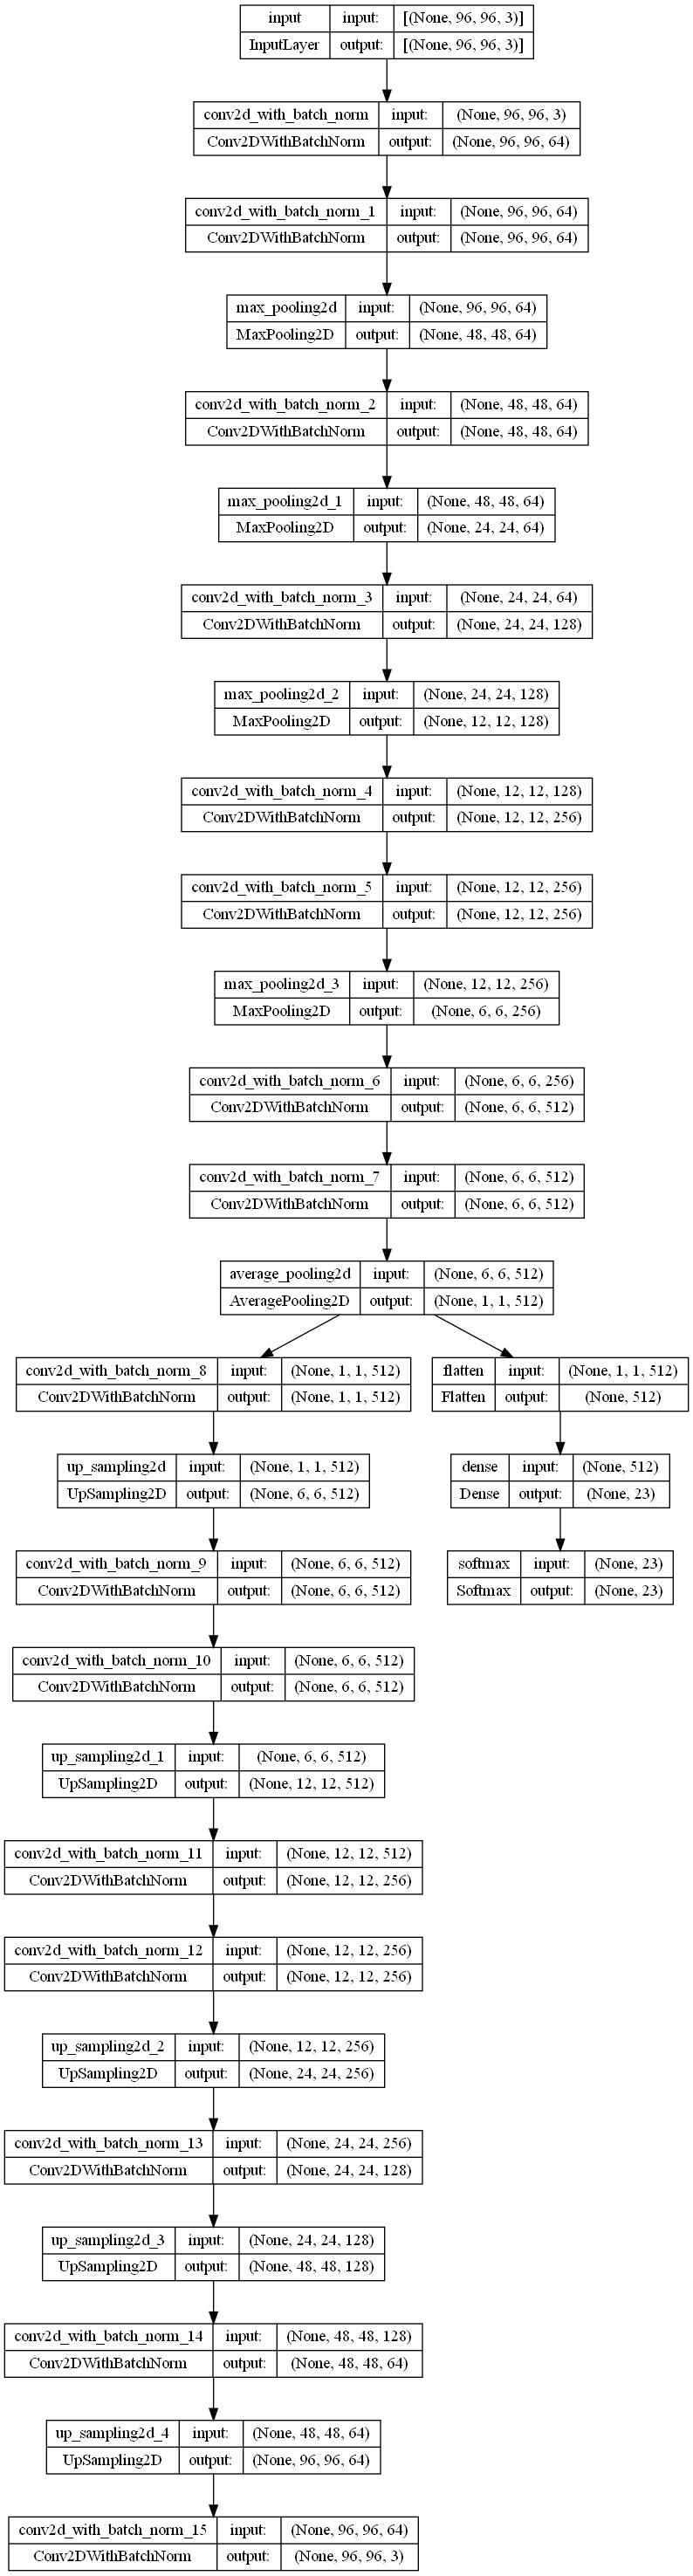

In [15]:
# irfan2020.summary()
keras.utils.plot_model(irfan2020, show_shapes=True)

In [20]:
irfan2020.fit(
    X_train,
    [X_train, y_train],
    batch_size=32,
    epochs=50,
)

evaluation = irfan2020.evaluate(
    X_test,
    [X_test, y_test] 
)

print(evaluation)

Epoch 1/50
599/599 [==============================] - 34s 57ms/step - loss: 25212.9961 - conv2d_with_batch_norm_15_loss: 25212.3555 - softmax_loss: 0.6245 - conv2d_with_batch_norm_15_accuracy: 0.5328 - softmax_accuracy: 0.8049
Epoch 2/50
599/599 [==============================] - 35s 58ms/step - loss: 24958.8242 - conv2d_with_batch_norm_15_loss: 24958.2871 - softmax_loss: 0.5578 - conv2d_with_batch_norm_15_accuracy: 0.5451 - softmax_accuracy: 0.8265
Epoch 3/50
599/599 [==============================] - 35s 58ms/step - loss: 24707.0039 - conv2d_with_batch_norm_15_loss: 24706.4844 - softmax_loss: 0.5229 - conv2d_with_batch_norm_15_accuracy: 0.5532 - softmax_accuracy: 0.8389
Epoch 4/50
599/599 [==============================] - 35s 58ms/step - loss: 24456.7344 - conv2d_with_batch_norm_15_loss: 24456.2422 - softmax_loss: 0.4900 - conv2d_with_batch_norm_15_accuracy: 0.5618 - softmax_accuracy: 0.8491
Epoch 5/50
599/599 [==============================] - 35s 58ms/step - loss: 24208.1152 - con

## Predicting and visualising reconstruction

In [ ]:
ae_imgs = irfan2020.predict(X_test)

# len(ae_imgs) == 2, one for reconstruction, one for classification
# ae_imgs[0].shape == (8211, 96, 96, 3)
# ae_imgs[1].shape == (8211, 23)

In [ ]:
class_predictions = np.argmax(ae_imgs[1], axis=1)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

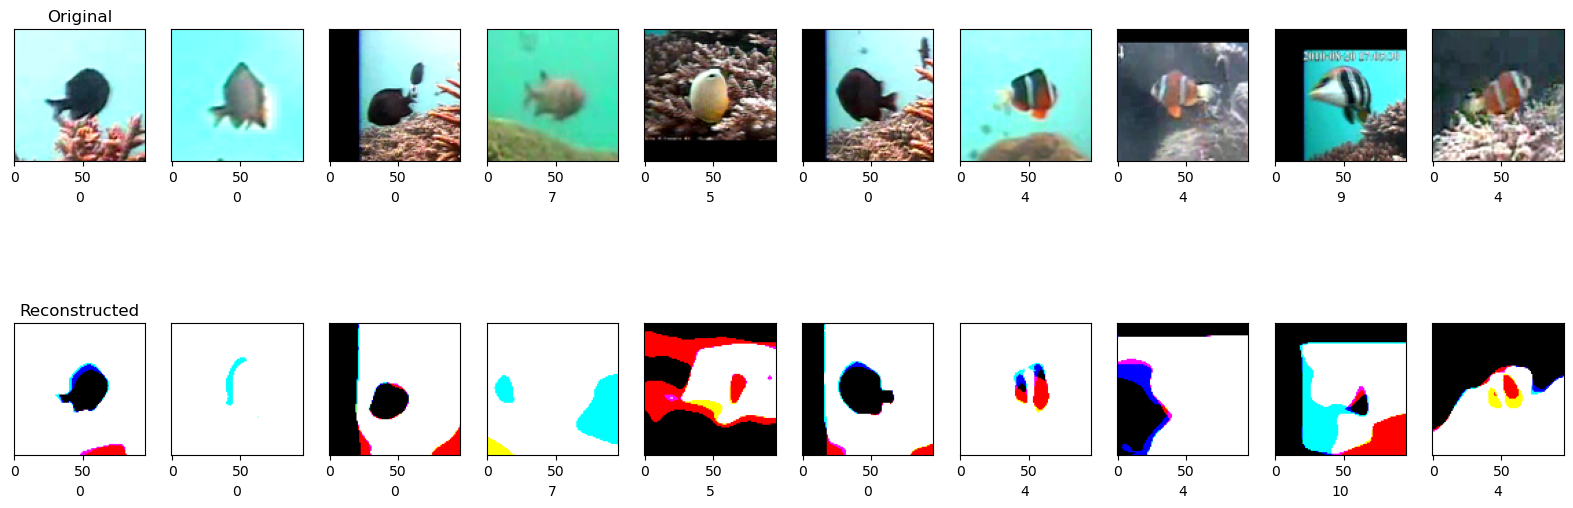

In [ ]:
n = 10
plt.figure(figsize=(20, 7))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(96, 96, 3))
    ax.set_xlabel(y_test[i])
    ax.get_yaxis().set_visible(False)
    plt.title("Original" if i == 0 else "")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(ae_imgs[0][i].reshape(96, 96, 3))
    ax.set_xlabel(class_predictions[i])
    ax.get_yaxis().set_visible(False)
    plt.title("Reconstructed" if i == 0 else "")
plt.show()